In [102]:
import pandas as pd


# 从附件1中读取数据。
df5 = pd.read_excel("./附件表/附件5-新品历史出货量表.xlsx")



df5.head()


,seller_no,warehouse_no,product_no,date,qty
0,seller_19,wh_21,product_2215,2023-05-08,2
1,seller_19,wh_21,product_2215,2023-04-11,2
2,seller_19,wh_21,product_2215,2023-05-14,22
3,seller_19,wh_21,product_2215,2023-04-15,1
4,seller_19,wh_21,product_2215,2023-04-29,3


In [103]:
df5['合并主键']=df5['seller_no']+df5['product_no']+df5['warehouse_no']

In [104]:
df5['合并主键'].nunique()

210

In [105]:
df5.groupby(['合并主键']).count()['qty'].max()

45

In [106]:
df5.groupby(['合并主键']).count()['qty'].min()

23

In [107]:
import pandas as pd

# 读取数据
df = pd.read_excel("./附件表/附件1-商家历史出货量表.xlsx")
df.head()


,seller_no,product_no,warehouse_no,date,qty
0,seller_19,product_448,wh_30,2023-05-09,10
1,seller_19,product_448,wh_30,2023-04-17,14
2,seller_19,product_448,wh_30,2023-01-09,2
3,seller_19,product_448,wh_30,2023-01-20,1
4,seller_19,product_448,wh_30,2023-02-13,22


In [108]:
# 构建 "合并主键" 列
df['合并主键'] = df['seller_no'] + df['product_no'] + df['warehouse_no']

# 按照 "合并主键" 和 "销售日期" 排序
df_sorted = df.sort_values(by=["合并主键", "date"], ascending=[True, False])
df_sorted.head()



,seller_no,product_no,warehouse_no,date,qty,合并主键
213415,seller_10,product_1664,wh_13,2023-05-15,0,seller_10product_1664wh_13
213444,seller_10,product_1664,wh_13,2023-05-14,0,seller_10product_1664wh_13
213399,seller_10,product_1664,wh_13,2023-05-13,0,seller_10product_1664wh_13
213461,seller_10,product_1664,wh_13,2023-05-12,0,seller_10product_1664wh_13
213434,seller_10,product_1664,wh_13,2023-05-11,0,seller_10product_1664wh_13


In [109]:
# 初始化一个空的DataFrame来保存结果
result_df = pd.DataFrame(columns=['合并主键'] + ['day_' + str(i) for i in range(1, 24)])

# 遍历每个 "合并主键"
for key, group in df_sorted.groupby('合并主键'):
    # 取最近的23天的销售量
    recent_23_days = group.head(23)['qty'].values
    # 如果数据不足23天，用0填充
    while len(recent_23_days) < 23:
        recent_23_days = np.append(recent_23_days, 0)
    result_df = result_df.append({'合并主键': key, **{'day_' + str(i): recent_23_days[i-1] for i in range(1, 24)}}, ignore_index=True)

result_df.head()


,合并主键,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23
0,seller_10product_1664wh_13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,seller_10product_1664wh_24,1,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,seller_10product_1914wh_1,0,0,1,1,3,2,1,1,3,...,1,0,2,1,1,1,0,0,1,2
3,seller_10product_1915wh_1,1,2,0,2,3,1,1,0,1,...,0,2,5,3,4,1,1,1,1,0
4,seller_10product_1916wh_1,0,0,1,1,4,0,0,0,1,...,1,3,4,0,1,2,1,1,1,1


In [110]:
import numpy as np
from scipy.stats import linregress
from statsmodels.tsa.stattools import acf, pacf

# 初始化一个空的DataFrame来保存特征
features_df = pd.DataFrame()
features_df['合并主键'] = result_df['合并主键']

# 1. 基础统计特征
features_df['均值'] = result_df.iloc[:, 1:].mean(axis=1)
features_df['中位数'] = result_df.iloc[:, 1:].median(axis=1)
features_df['方差'] = result_df.iloc[:, 1:].var(axis=1)
features_df['标准差'] = result_df.iloc[:, 1:].std(axis=1)
features_df['最大值'] = result_df.iloc[:, 1:].max(axis=1)
features_df['最小值'] = result_df.iloc[:, 1:].min(axis=1)

from sklearn.linear_model import LinearRegression

def trend_feature(row):
    X = np.arange(23).reshape(-1, 1)
    y = row[1:].values
    model = LinearRegression().fit(X, y)
    return model.coef_[0]

features_df['趋势'] = result_df.apply(trend_feature, axis=1)


# 3. 滞后特征
# 这里我们取1天和2天的滞后
features_df['滞后1天'] = result_df['day_1'].shift(periods=1, fill_value=0)
features_df['滞后2天'] = result_df['day_1'].shift(periods=2, fill_value=0)




In [111]:
features_df

,合并主键,均值,中位数,方差,标准差,最大值,最小值,趋势,滞后1天,滞后2天
0,seller_10product_1664wh_13,0.043478,0.0,0.043478,0.208514,1.0,0.0,0.006917,0,0
1,seller_10product_1664wh_24,0.130435,0.0,0.209486,0.457697,2.0,0.0,-0.024704,0,0
2,seller_10product_1914wh_1,1.304348,1.0,0.948617,0.973970,3.0,0.0,-0.012846,1,0
3,seller_10product_1915wh_1,1.695652,1.0,1.857708,1.362977,5.0,0.0,0.014822,0,1
4,seller_10product_1916wh_1,1.304348,1.0,1.675889,1.294561,4.0,0.0,0.036561,1,0
...,...,...,...,...,...,...,...,...,...,...
1991,seller_9product_95wh_12,1.782609,2.0,1.814229,1.346933,5.0,0.0,-0.035573,6,0
1992,seller_9product_96wh_1,22.608696,22.0,37.885375,6.155110,34.0,7.0,-0.251976,2,6
1993,seller_9product_96wh_12,4.391304,4.0,3.249012,1.802502,8.0,0.0,-0.089921,30,2
1994,seller_9product_96wh_13,5.391304,5.0,7.158103,2.675463,11.0,1.0,-0.174901,8,30


In [112]:
result_df

,合并主键,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23
0,seller_10product_1664wh_13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,seller_10product_1664wh_24,1,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,seller_10product_1914wh_1,0,0,1,1,3,2,1,1,3,...,1,0,2,1,1,1,0,0,1,2
3,seller_10product_1915wh_1,1,2,0,2,3,1,1,0,1,...,0,2,5,3,4,1,1,1,1,0
4,seller_10product_1916wh_1,0,0,1,1,4,0,0,0,1,...,1,3,4,0,1,2,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,seller_9product_95wh_12,2,0,1,2,4,2,2,4,1,...,1,3,2,0,1,1,2,2,0,1
1992,seller_9product_96wh_1,30,30,19,25,22,34,20,24,25,...,23,15,13,17,26,21,26,21,22,22
1993,seller_9product_96wh_12,8,6,4,7,4,5,4,6,5,...,6,2,3,3,5,4,7,3,3,5
1994,seller_9product_96wh_13,8,11,4,7,5,10,4,6,8,...,3,5,3,4,4,2,5,8,6,1


In [113]:
df=pd.concat([result_df,features_df[features_df.columns[1:]]],axis=1)

In [114]:
df

,合并主键,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_23,均值,中位数,方差,标准差,最大值,最小值,趋势,滞后1天,滞后2天
0,seller_10product_1664wh_13,0,0,0,0,0,0,0,0,0,...,0,0.043478,0.0,0.043478,0.208514,1.0,0.0,0.006917,0,0
1,seller_10product_1664wh_24,1,0,0,0,2,0,0,0,0,...,0,0.130435,0.0,0.209486,0.457697,2.0,0.0,-0.024704,0,0
2,seller_10product_1914wh_1,0,0,1,1,3,2,1,1,3,...,2,1.304348,1.0,0.948617,0.973970,3.0,0.0,-0.012846,1,0
3,seller_10product_1915wh_1,1,2,0,2,3,1,1,0,1,...,0,1.695652,1.0,1.857708,1.362977,5.0,0.0,0.014822,0,1
4,seller_10product_1916wh_1,0,0,1,1,4,0,0,0,1,...,1,1.304348,1.0,1.675889,1.294561,4.0,0.0,0.036561,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,seller_9product_95wh_12,2,0,1,2,4,2,2,4,1,...,1,1.782609,2.0,1.814229,1.346933,5.0,0.0,-0.035573,6,0
1992,seller_9product_96wh_1,30,30,19,25,22,34,20,24,25,...,22,22.608696,22.0,37.885375,6.155110,34.0,7.0,-0.251976,2,6
1993,seller_9product_96wh_12,8,6,4,7,4,5,4,6,5,...,5,4.391304,4.0,3.249012,1.802502,8.0,0.0,-0.089921,30,2
1994,seller_9product_96wh_13,8,11,4,7,5,10,4,6,8,...,1,5.391304,5.0,7.158103,2.675463,11.0,1.0,-0.174901,8,30


In [116]:
df5

,seller_no,warehouse_no,product_no,date,qty,合并主键
0,seller_19,wh_21,product_2215,2023-05-08,2,seller_19product_2215wh_21
1,seller_19,wh_21,product_2215,2023-04-11,2,seller_19product_2215wh_21
2,seller_19,wh_21,product_2215,2023-05-14,22,seller_19product_2215wh_21
3,seller_19,wh_21,product_2215,2023-04-15,1,seller_19product_2215wh_21
4,seller_19,wh_21,product_2215,2023-04-29,3,seller_19product_2215wh_21
...,...,...,...,...,...,...
7424,seller_1,wh_3,product_8,2023-04-12,0,seller_1product_8wh_3
7425,seller_1,wh_3,product_8,2023-05-04,0,seller_1product_8wh_3
7426,seller_1,wh_3,product_8,2023-04-16,4,seller_1product_8wh_3
7427,seller_1,wh_3,product_8,2023-05-05,4,seller_1product_8wh_3


In [117]:
# 按照 "合并主键" 和 "销售日期" 排序
df5_sorted = df5.sort_values(by=["合并主键", "date"], ascending=[True, False])
df5_sorted.head()
# 初始化一个空的DataFrame来保存结果
result_df5 = pd.DataFrame(columns=['合并主键'] + ['day_' + str(i) for i in range(1, 24)])

# 遍历每个 "合并主键"
for key, group in df5_sorted.groupby('合并主键'):
    # 取最近的23天的销售量
    recent_23_days = group.head(23)['qty'].values
    # 如果数据不足23天，用0填充
    while len(recent_23_days) < 23:
        recent_23_days = np.append(recent_23_days, 0)
    result_df5 = result_df5.append({'合并主键': key, **{'day_' + str(i): recent_23_days[i-1] for i in range(1, 24)}}, ignore_index=True)

result_df5.head()


,合并主键,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23
0,seller_11product_2154wh_1,0,6,0,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,seller_11product_2160wh_1,8,8,4,3,11,4,5,10,1,...,1,7,5,4,2,2,1,7,7,6
2,seller_11product_2160wh_17,1,0,2,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,2,0
3,seller_12product_2097wh_26,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
4,seller_12product_2105wh_1,11,16,5,3,16,11,17,16,4,...,6,6,6,7,3,4,1,3,6,3


In [118]:

# 初始化一个空的DataFrame来保存特征
features_df5 = pd.DataFrame()
features_df5['合并主键'] = result_df5['合并主键']

# 1. 基础统计特征
features_df5['均值'] = result_df5.iloc[:, 1:].mean(axis=1)
features_df5['中位数'] = result_df5.iloc[:, 1:].median(axis=1)
features_df5['方差'] = result_df5.iloc[:, 1:].var(axis=1)
features_df5['标准差'] = result_df5.iloc[:, 1:].std(axis=1)
features_df5['最大值'] = result_df5.iloc[:, 1:].max(axis=1)
features_df5['最小值'] = result_df5.iloc[:, 1:].min(axis=1)


features_df5['趋势'] = result_df5.apply(trend_feature, axis=1)


# 3. 滞后特征
# 这里我们取1天和2天的滞后
features_df5['滞后1天'] = result_df5['day_1'].shift(periods=1, fill_value=0)
features_df5['滞后2天'] = result_df5['day_1'].shift(periods=2, fill_value=0)


df5=pd.concat([result_df5,features_df5[features_df5.columns[1:]]],axis=1)

df5


,合并主键,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_23,均值,中位数,方差,标准差,最大值,最小值,趋势,滞后1天,滞后2天
0,seller_11product_2154wh_1,0,6,0,0,0,6,0,0,0,...,0,0.565217,0.0,2.984190,1.727481,6.0,0.0,-0.094862,0,0
1,seller_11product_2160wh_1,8,8,4,3,11,4,5,10,1,...,6,4.956522,4.0,9.043478,3.007238,11.0,1.0,-0.115613,0,0
2,seller_11product_2160wh_17,1,0,2,0,0,0,1,1,0,...,0,0.347826,0.0,0.418972,0.647281,2.0,0.0,-0.014822,8,0
3,seller_12product_2097wh_26,1,0,0,0,0,1,0,0,0,...,0,0.260870,0.0,0.201581,0.448978,1.0,0.0,0.002964,1,8
4,seller_12product_2105wh_1,11,16,5,3,16,11,17,16,4,...,3,7.739130,6.0,25.747036,5.074154,17.0,1.0,-0.449605,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,seller_9product_2122wh_13,1,0,1,2,1,0,2,1,2,...,0,0.913043,1.0,0.810277,0.900154,3.0,0.0,-0.001976,2,9
206,seller_9product_2122wh_14,1,0,2,0,3,3,1,0,0,...,0,1.043478,1.0,1.134387,1.065076,3.0,0.0,-0.034585,1,2
207,seller_9product_2122wh_15,0,0,0,1,0,1,0,0,0,...,0,0.130435,0.0,0.118577,0.344350,1.0,0.0,-0.006917,1,1
208,seller_9product_2124wh_12,1,0,0,2,2,4,2,0,2,...,3,2.086957,2.0,2.355731,1.534839,5.0,0.0,0.046443,0,1


In [121]:
df.shape

(1996, 33)

In [122]:
ttemp=pd.concat([df,df5])
ttemp

,合并主键,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_23,均值,中位数,方差,标准差,最大值,最小值,趋势,滞后1天,滞后2天
0,seller_10product_1664wh_13,-0.360122,-0.350136,-0.395132,-0.366962,-0.371051,-0.345596,-0.345066,-0.392269,-0.383705,...,-0.325015,-0.365314,-0.365838,-0.062132,-0.373486,-0.356021,-0.242081,0.011037,-0.360122,-0.360014
1,seller_10product_1664wh_24,-0.335704,-0.350136,-0.395132,-0.366962,-0.319386,-0.345596,-0.345066,-0.392269,-0.383705,...,-0.325015,-0.363047,-0.365838,-0.062105,-0.359973,-0.344641,-0.242081,-0.014454,-0.360122,-0.360014
2,seller_10product_1914wh_1,-0.360122,-0.350136,-0.36539,-0.339603,-0.293553,-0.297115,-0.322746,-0.363676,-0.297273,...,-0.273096,-0.332447,-0.336850,-0.061988,-0.331976,-0.333261,-0.242081,-0.004895,-0.335704,-0.360014
3,seller_10product_1915wh_1,-0.335704,-0.298881,-0.395132,-0.312244,-0.293553,-0.321355,-0.322746,-0.392269,-0.354894,...,-0.325015,-0.322247,-0.336850,-0.061843,-0.310881,-0.310501,-0.242081,0.017410,-0.360122,-0.335598
4,seller_10product_1916wh_1,-0.360122,-0.350136,-0.36539,-0.339603,-0.267721,-0.345596,-0.345066,-0.392269,-0.354894,...,-0.299055,-0.332447,-0.336850,-0.061872,-0.314591,-0.321881,-0.242081,0.034935,-0.335704,-0.360014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,seller_9product_2122wh_13,1,0,1,2,1,0,2,1,2,...,0,0.913043,1.000000,0.810277,0.900154,3.000000,0.000000,-0.001976,2,9
206,seller_9product_2122wh_14,1,0,2,0,3,3,1,0,0,...,0,1.043478,1.000000,1.134387,1.065076,3.000000,0.000000,-0.034585,1,2
207,seller_9product_2122wh_15,0,0,0,1,0,1,0,0,0,...,0,0.130435,0.000000,0.118577,0.344350,1.000000,0.000000,-0.006917,1,1
208,seller_9product_2124wh_12,1,0,0,2,2,4,2,0,2,...,3,2.086957,2.000000,2.355731,1.534839,5.000000,0.000000,0.046443,0,1


In [123]:
from sklearn.preprocessing import StandardScaler

# 数据标准化
scaler = StandardScaler()
ttemp[ttemp.columns[1:]] = scaler.fit_transform(ttemp[ttemp.columns[1:]])

ttemp.head()

,合并主键,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_23,均值,中位数,方差,标准差,最大值,最小值,趋势,滞后1天,滞后2天
0,seller_10product_1664wh_13,-0.077302,-0.092221,-0.098620,-0.095242,-0.084524,-0.084530,-0.078641,-0.084464,-0.077295,...,-0.072092,-0.086225,-0.084231,-0.029003,-0.150428,-0.092646,-0.064411,0.042066,-0.077157,-0.077139
1,seller_10product_1664wh_24,-0.076516,-0.092221,-0.098620,-0.095242,-0.081344,-0.084530,-0.078641,-0.084464,-0.077295,...,-0.072092,-0.086082,-0.084231,-0.029003,-0.148279,-0.092293,-0.064411,0.017959,-0.077157,-0.077139
2,seller_10product_1914wh_1,-0.077302,-0.092221,-0.096629,-0.093314,-0.079754,-0.081454,-0.077459,-0.082772,-0.072803,...,-0.068825,-0.084155,-0.082222,-0.029003,-0.143826,-0.091941,-0.064411,0.026999,-0.076371,-0.077139
3,seller_10product_1915wh_1,-0.076516,-0.089268,-0.098620,-0.091387,-0.079754,-0.082992,-0.077459,-0.084464,-0.075798,...,-0.072092,-0.083512,-0.082222,-0.029003,-0.140471,-0.091236,-0.064411,0.048093,-0.077157,-0.076353
4,seller_10product_1916wh_1,-0.077302,-0.092221,-0.096629,-0.093314,-0.078164,-0.084530,-0.078641,-0.084464,-0.075798,...,-0.070458,-0.084155,-0.082222,-0.029003,-0.141061,-0.091588,-0.064411,0.064667,-0.076371,-0.077139


In [124]:
ttemp

,合并主键,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_23,均值,中位数,方差,标准差,最大值,最小值,趋势,滞后1天,滞后2天
0,seller_10product_1664wh_13,-0.077302,-0.092221,-0.098620,-0.095242,-0.084524,-0.084530,-0.078641,-0.084464,-0.077295,...,-0.072092,-0.086225,-0.084231,-0.029003,-0.150428,-0.092646,-0.064411,0.042066,-0.077157,-0.077139
1,seller_10product_1664wh_24,-0.076516,-0.092221,-0.098620,-0.095242,-0.081344,-0.084530,-0.078641,-0.084464,-0.077295,...,-0.072092,-0.086082,-0.084231,-0.029003,-0.148279,-0.092293,-0.064411,0.017959,-0.077157,-0.077139
2,seller_10product_1914wh_1,-0.077302,-0.092221,-0.096629,-0.093314,-0.079754,-0.081454,-0.077459,-0.082772,-0.072803,...,-0.068825,-0.084155,-0.082222,-0.029003,-0.143826,-0.091941,-0.064411,0.026999,-0.076371,-0.077139
3,seller_10product_1915wh_1,-0.076516,-0.089268,-0.098620,-0.091387,-0.079754,-0.082992,-0.077459,-0.084464,-0.075798,...,-0.072092,-0.083512,-0.082222,-0.029003,-0.140471,-0.091236,-0.064411,0.048093,-0.077157,-0.076353
4,seller_10product_1916wh_1,-0.077302,-0.092221,-0.096629,-0.093314,-0.078164,-0.084530,-0.078641,-0.084464,-0.075798,...,-0.070458,-0.084155,-0.082222,-0.029003,-0.141061,-0.091588,-0.064411,0.064667,-0.076371,-0.077139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,seller_9product_2122wh_13,-0.033486,-0.072045,-0.005220,0.071499,-0.000139,-0.062606,0.045535,-0.002092,0.046606,...,-0.051645,-0.005716,0.010431,-0.028354,0.052147,0.011318,-0.039413,0.029759,-0.001124,0.224400
206,seller_9product_2122wh_14,-0.033486,-0.072045,0.061728,-0.069391,0.122955,0.127713,-0.007417,-0.061256,-0.057351,...,-0.051645,0.002499,0.010431,-0.028113,0.078379,0.011318,-0.039413,-0.001079,-0.033340,-0.001110
207,seller_9product_2122wh_15,-0.065701,-0.072045,-0.072167,0.001054,-0.061687,0.000834,-0.060369,-0.061256,-0.057351,...,-0.051645,-0.055003,-0.058876,-0.028868,-0.036255,-0.050638,-0.039413,0.025087,-0.033340,-0.033326
208,seller_9product_2124wh_12,-0.033486,-0.072045,-0.072167,0.071499,0.061408,0.191153,0.045535,-0.061256,0.046606,...,0.137083,0.068215,0.079737,-0.027205,0.153096,0.073275,-0.039413,0.075549,-0.065556,-0.033326


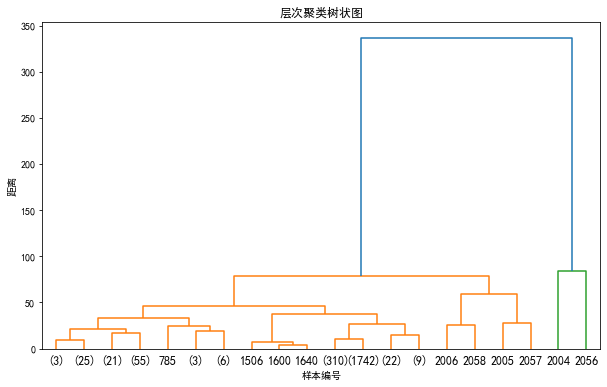

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from collections import Counter

# 假设X是你的数据
X = ttemp[ttemp.columns[1:33]]

# 使用层次聚类方法
linkage_matrix = linkage(X, method='ward', metric='euclidean')

# 绘制树状图（树状图可以帮助选择最优聚类数量）
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.xlabel('样本编号')
plt.ylabel('距离')
plt.title('层次聚类树状图')
plt.show()


In [127]:
# 根据树状图选择最优聚类数量
k = 2  # 假设最优聚类数量为3
labels = fcluster(linkage_matrix, k, criterion='maxclust')

# 将聚类标签添加到原始数据中
ttemp['层次聚类标签'] = labels


In [128]:
from collections import Counter
Counter(ttemp['层次聚类标签'])

Counter({1: 2204, 2: 2})

In [129]:


from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 肘部法则
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(ttemp[ttemp.columns[1:33]])
    sse.append(km.inertia_)



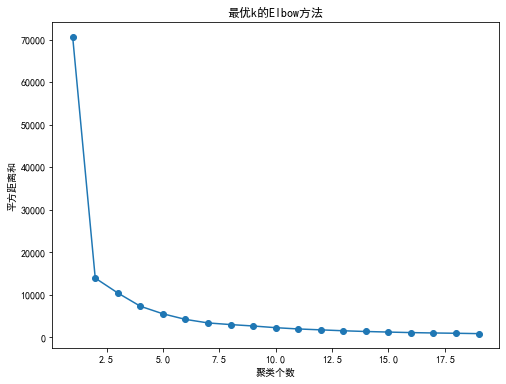

In [130]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 绘制图表
plt.figure(figsize=(8, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('聚类个数')
plt.ylabel('平方距离和')
plt.title('最优k的Elbow方法')
plt.show()

In [131]:
# 设置k=4并进行KMeans聚类
kmeans = KMeans(n_clusters=5, random_state=0)
ttemp['KMeans聚类'] = kmeans.fit_predict(ttemp[ttemp.columns[1:33]])


In [132]:
from collections import Counter
Counter(ttemp['KMeans聚类'])

Counter({0: 2200, 1: 1, 3: 2, 4: 2, 2: 1})

In [134]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 读取数据，假设X是你的特征数据
X = ttemp[ttemp.columns[1:33]]

# 初始化DBSCAN模型，设置epsilon和min_samples参数

dbscan = DBSCAN()

# 使用DBSCAN进行聚类
labels = dbscan.fit_predict(X)

# 统计每个聚类标签的频数
label_counts = pd.Series(labels).value_counts()

# 打印每个聚类标签的频数
print("Cluster Label Counts:\n", label_counts)

# 选择最优的聚类数量
optimal_clusters = label_counts[label_counts > 1].count()  # 至少包含两个样本的簇
print("Optimal Number of Clusters:", optimal_clusters)



Cluster Label Counts:
  0    2019
-1     187
dtype: int64
Optimal Number of Clusters: 2


In [136]:
ttemp['DBSCAN聚类'] = labels

In [162]:
from collections import Counter
Counter(ttemp['DBSCAN聚类'])

Counter({0: 2019, -1: 187})

In [137]:
ttemp

,合并主键,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,方差,标准差,最大值,最小值,趋势,滞后1天,滞后2天,层次聚类标签,KMeans聚类,DBSCAN聚类
0,seller_10product_1664wh_13,-0.077302,-0.092221,-0.098620,-0.095242,-0.084524,-0.084530,-0.078641,-0.084464,-0.077295,...,-0.029003,-0.150428,-0.092646,-0.064411,0.042066,-0.077157,-0.077139,1,0,0
1,seller_10product_1664wh_24,-0.076516,-0.092221,-0.098620,-0.095242,-0.081344,-0.084530,-0.078641,-0.084464,-0.077295,...,-0.029003,-0.148279,-0.092293,-0.064411,0.017959,-0.077157,-0.077139,1,0,0
2,seller_10product_1914wh_1,-0.077302,-0.092221,-0.096629,-0.093314,-0.079754,-0.081454,-0.077459,-0.082772,-0.072803,...,-0.029003,-0.143826,-0.091941,-0.064411,0.026999,-0.076371,-0.077139,1,0,0
3,seller_10product_1915wh_1,-0.076516,-0.089268,-0.098620,-0.091387,-0.079754,-0.082992,-0.077459,-0.084464,-0.075798,...,-0.029003,-0.140471,-0.091236,-0.064411,0.048093,-0.077157,-0.076353,1,0,0
4,seller_10product_1916wh_1,-0.077302,-0.092221,-0.096629,-0.093314,-0.078164,-0.084530,-0.078641,-0.084464,-0.075798,...,-0.029003,-0.141061,-0.091588,-0.064411,0.064667,-0.076371,-0.077139,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,seller_9product_2122wh_13,-0.033486,-0.072045,-0.005220,0.071499,-0.000139,-0.062606,0.045535,-0.002092,0.046606,...,-0.028354,0.052147,0.011318,-0.039413,0.029759,-0.001124,0.224400,1,0,0
206,seller_9product_2122wh_14,-0.033486,-0.072045,0.061728,-0.069391,0.122955,0.127713,-0.007417,-0.061256,-0.057351,...,-0.028113,0.078379,0.011318,-0.039413,-0.001079,-0.033340,-0.001110,1,0,0
207,seller_9product_2122wh_15,-0.065701,-0.072045,-0.072167,0.001054,-0.061687,0.000834,-0.060369,-0.061256,-0.057351,...,-0.028868,-0.036255,-0.050638,-0.039413,0.025087,-0.033340,-0.033326,1,0,0
208,seller_9product_2124wh_12,-0.033486,-0.072045,-0.072167,0.071499,0.061408,0.191153,0.045535,-0.061256,0.046606,...,-0.027205,0.153096,0.073275,-0.039413,0.075549,-0.065556,-0.033326,1,0,-1


In [141]:
Xdf5=ttemp.iloc[-210:]
Xdf1=ttemp.iloc[:-210]

In [142]:
Xdf1

,合并主键,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,方差,标准差,最大值,最小值,趋势,滞后1天,滞后2天,层次聚类标签,KMeans聚类,DBSCAN聚类
0,seller_10product_1664wh_13,-0.077302,-0.092221,-0.098620,-0.095242,-0.084524,-0.084530,-0.078641,-0.084464,-0.077295,...,-0.029003,-0.150428,-0.092646,-0.064411,0.042066,-0.077157,-0.077139,1,0,0
1,seller_10product_1664wh_24,-0.076516,-0.092221,-0.098620,-0.095242,-0.081344,-0.084530,-0.078641,-0.084464,-0.077295,...,-0.029003,-0.148279,-0.092293,-0.064411,0.017959,-0.077157,-0.077139,1,0,0
2,seller_10product_1914wh_1,-0.077302,-0.092221,-0.096629,-0.093314,-0.079754,-0.081454,-0.077459,-0.082772,-0.072803,...,-0.029003,-0.143826,-0.091941,-0.064411,0.026999,-0.076371,-0.077139,1,0,0
3,seller_10product_1915wh_1,-0.076516,-0.089268,-0.098620,-0.091387,-0.079754,-0.082992,-0.077459,-0.084464,-0.075798,...,-0.029003,-0.140471,-0.091236,-0.064411,0.048093,-0.077157,-0.076353,1,0,0
4,seller_10product_1916wh_1,-0.077302,-0.092221,-0.096629,-0.093314,-0.078164,-0.084530,-0.078641,-0.084464,-0.075798,...,-0.029003,-0.141061,-0.091588,-0.064411,0.064667,-0.076371,-0.077139,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,seller_9product_95wh_12,-0.075729,-0.092221,-0.096629,-0.091387,-0.078164,-0.081454,-0.076277,-0.077697,-0.075798,...,-0.029003,-0.140609,-0.091236,-0.064411,0.009672,-0.072438,-0.077139,1,0,0
1992,seller_9product_96wh_1,-0.053704,-0.047917,-0.060788,-0.047059,-0.049546,-0.032245,-0.055003,-0.043863,-0.039857,...,-0.028998,-0.099138,-0.081012,-0.029792,-0.155312,-0.075584,-0.072420,1,0,0
1993,seller_9product_96wh_12,-0.071009,-0.083361,-0.090656,-0.081751,-0.078164,-0.076841,-0.073913,-0.074314,-0.069808,...,-0.029002,-0.136680,-0.090178,-0.064411,-0.031762,-0.053559,-0.075566,1,0,0
1994,seller_9product_96wh_13,-0.071009,-0.075976,-0.090656,-0.081751,-0.076574,-0.069152,-0.073913,-0.074314,-0.065315,...,-0.029002,-0.129150,-0.089120,-0.059465,-0.096551,-0.070864,-0.053541,1,0,0


In [203]:
aa=Xdf1[Xdf1['DBSCAN聚类']==0][Xdf1.columns[1:33]].T
aa[-1]=Xdf5.iloc[i][Xdf5.columns[1:33]].T.map(float)
aa

,0,1,2,3,4,5,6,7,8,9,...,1987,1988,1989,1990,1991,1992,1993,1994,1995,-1
day_1,-0.077302,-0.076516,-0.077302,-0.076516,-0.077302,-0.076516,-0.076516,-0.077302,-0.077302,-0.077302,...,-0.074942,-0.077302,-0.077302,-0.072583,-0.075729,-0.053704,-0.071009,-0.071009,-0.077302,-0.065701
day_2,-0.092221,-0.092221,-0.092221,-0.089268,-0.092221,-0.087791,-0.092221,-0.089268,-0.087791,-0.092221,...,-0.087791,-0.090745,-0.089268,-0.086314,-0.092221,-0.047917,-0.083361,-0.075976,-0.090745,0.273707
day_3,-0.098620,-0.098620,-0.096629,-0.098620,-0.096629,-0.096629,-0.098620,-0.094638,-0.098620,-0.096629,...,-0.092647,-0.096629,-0.096629,-0.078709,-0.096629,-0.060788,-0.090656,-0.090656,-0.092647,-0.072167
day_4,-0.095242,-0.095242,-0.093314,-0.091387,-0.093314,-0.093314,-0.093314,-0.095242,-0.087533,-0.095242,...,-0.087533,-0.089460,-0.093314,-0.079823,-0.091387,-0.047059,-0.081751,-0.081751,-0.091387,-0.069391
day_5,-0.084524,-0.081344,-0.079754,-0.079754,-0.078164,-0.082934,-0.081344,-0.082934,-0.084524,-0.084524,...,-0.082934,-0.084524,-0.079754,-0.067035,-0.078164,-0.049546,-0.078164,-0.076574,-0.082934,-0.061687
day_6,-0.084530,-0.084530,-0.081454,-0.082992,-0.084530,-0.082992,-0.084530,-0.079917,-0.079917,-0.084530,...,-0.079917,-0.081454,-0.081454,-0.075303,-0.081454,-0.032245,-0.076841,-0.069152,-0.073765,0.318032
day_7,-0.078641,-0.078641,-0.077459,-0.077459,-0.078641,-0.078641,-0.078641,-0.076277,-0.078641,-0.077459,...,-0.073913,-0.077459,-0.076277,-0.070368,-0.076277,-0.055003,-0.073913,-0.073913,-0.076277,-0.060369
day_8,-0.084464,-0.084464,-0.082772,-0.084464,-0.084464,-0.082772,-0.084464,-0.082772,-0.082772,-0.081081,...,-0.077697,-0.076006,-0.081081,-0.064164,-0.077697,-0.043863,-0.074314,-0.074314,-0.079389,-0.061256
day_9,-0.077295,-0.077295,-0.072803,-0.075798,-0.075798,-0.075798,-0.077295,-0.072803,-0.077295,-0.075798,...,-0.069808,-0.075798,-0.075798,-0.066812,-0.075798,-0.039857,-0.069808,-0.065315,-0.074300,-0.057351
day_10,-0.075048,-0.075048,-0.072388,-0.072388,-0.075048,-0.071058,-0.075048,-0.071058,-0.072388,-0.075048,...,-0.073718,-0.075048,-0.073718,-0.071058,-0.075048,-0.048446,-0.069727,-0.072388,-0.069727,-0.057039


In [209]:
corr=aa.corr()

In [227]:
bb=corr[-1].nlargest(2).index[-1]
bb

1557

In [228]:
bb

1557

'seller_33product_1315wh_1'

In [243]:
Data=[]
for i in range(len(Xdf5)):
    if i%10==0:
        print('%d/210'%(i+1))
    cc=Xdf5['DBSCAN聚类'].iloc[i]
    temppp=Xdf1[Xdf1['DBSCAN聚类']==cc]
    aa=temppp[Xdf1.columns[1:33]].T
    aa[-1]=Xdf5.iloc[i][Xdf5.columns[1:33]].T.map(float)

    bb=aa.corr()[-1].nlargest(2)
    ee=bb.index[-1]#第二大值对应的索引
    ff=bb.iloc[-1]#第二大值
    Data.append([Xdf1.iloc[ee]['合并主键'],ff])#对应的合并主键，相关系数
    

1/210
11/210
21/210
31/210
41/210
51/210
61/210
71/210
81/210
91/210
101/210
111/210
121/210
131/210
141/210
151/210
161/210
171/210
181/210
191/210
201/210


In [259]:
ee

294

In [258]:
Xdf1.iloc[ee]['合并主键']

'seller_12product_323wh_1'

In [247]:
Data1=pd.DataFrame(Data,columns=['对应附件1合并主键','相关系数'])
Data1

,对应附件1合并主键,相关系数
0,seller_33product_1315wh_1,0.402954
1,seller_33product_1362wh_29,0.449254
2,seller_33product_1339wh_1,0.542998
3,seller_21product_475wh_1,0.780410
4,seller_14product_214wh_1,0.514967
...,...,...
205,seller_35product_1427wh_1,0.546023
206,seller_32product_1055wh_1,0.453090
207,seller_32product_1057wh_1,0.710699
208,seller_32product_1079wh_1,0.422830


In [251]:
Data1['附件5合并主键']=Xdf5['合并主键']

In [262]:
data1=pd.read_excel('./结果表/结果表1-预测结果表.xlsx')
data1

,seller_no,product_no,warehouse_no,date,forecast_qty
0,seller_19,product_448,wh_30,2023-05-16 至 2023-05-30,161
1,seller_11,product_148,wh_1,2023-05-16 至 2023-05-30,279
2,seller_11,product_132,wh_16,2023-05-16 至 2023-05-30,23
3,seller_11,product_170,wh_9,2023-05-16 至 2023-05-30,71
4,seller_11,product_184,wh_18,2023-05-16 至 2023-05-30,182
...,...,...,...,...,...
1991,seller_32,product_1061,wh_1,2023-05-16 至 2023-05-30,118
1992,seller_32,product_1112,wh_29,2023-05-16 至 2023-05-30,286
1993,seller_15,product_830,wh_1,2023-05-16 至 2023-05-30,494
1994,seller_21,product_494,wh_33,2023-05-16 至 2023-05-30,9


In [263]:
data1['合并主键']=data1['seller_no']+data1['product_no']+data1['warehouse_no']

In [270]:
over=pd.merge(data1,Data1,left_on='合并主键',right_on='对应附件1合并主键',how='right')[['附件5合并主键','forecast_qty']]
over

,附件5合并主键,forecast_qty
0,seller_11product_2154wh_1,48
1,seller_11product_2160wh_1,970
2,seller_11product_2160wh_17,107
3,seller_12product_2097wh_26,16
4,seller_12product_2105wh_1,2654
...,...,...
205,seller_9product_2122wh_13,286
206,seller_9product_2122wh_14,697
207,seller_9product_2122wh_15,145
208,seller_9product_2124wh_12,2378


In [278]:
import re
def getre(x):
    # 使用正则表达式进行拆解
    pattern = r"([a-zA-Z_]+\d+)"
    return re.findall(pattern, x)

ppp=[]
for i in over['附件5合并主键']:
    ppp.append(getre(i))

In [282]:
dfoutput=pd.concat([pd.DataFrame(ppp,columns=['seller_no','product_no','warehouse_no']),over['forecast_qty']],axis=1)
dfoutput

,seller_no,product_no,warehouse_no,forecast_qty
0,seller_11,product_2154,wh_1,48
1,seller_11,product_2160,wh_1,970
2,seller_11,product_2160,wh_17,107
3,seller_12,product_2097,wh_26,16
4,seller_12,product_2105,wh_1,2654
...,...,...,...,...
205,seller_9,product_2122,wh_13,286
206,seller_9,product_2122,wh_14,697
207,seller_9,product_2122,wh_15,145
208,seller_9,product_2124,wh_12,2378


In [281]:
data2=pd.read_excel('./结果表/结果表2-预测结果表.xlsx')
data2

,seller_no,product_no,warehouse_no,date,forecast_qty


In [284]:
data2['seller_no']=dfoutput['seller_no']
data2['product_no']=dfoutput['product_no']
data2['warehouse_no']=dfoutput['warehouse_no']
data2['date']='2023-05-16 至 2023-05-30'
data2['forecast_qty']=dfoutput['forecast_qty']
data2.to_excel('./结果表/结果表2-预测结果表.xlsx',index=None)

In [285]:
data2

,seller_no,product_no,warehouse_no,date,forecast_qty
0,seller_11,product_2154,wh_1,2023-05-16 至 2023-05-30,48
1,seller_11,product_2160,wh_1,2023-05-16 至 2023-05-30,970
2,seller_11,product_2160,wh_17,2023-05-16 至 2023-05-30,107
3,seller_12,product_2097,wh_26,2023-05-16 至 2023-05-30,16
4,seller_12,product_2105,wh_1,2023-05-16 至 2023-05-30,2654
...,...,...,...,...,...
205,seller_9,product_2122,wh_13,2023-05-16 至 2023-05-30,286
206,seller_9,product_2122,wh_14,2023-05-16 至 2023-05-30,697
207,seller_9,product_2122,wh_15,2023-05-16 至 2023-05-30,145
208,seller_9,product_2124,wh_12,2023-05-16 至 2023-05-30,2378
